NOTE:- I researched and felt that EfficientNetV2 might be a good fit for this task.

## A. IMPORT STATEMENTS

In [1]:
# Import Statements
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb
import random

## B. SET UP FOR DEVICE AGNOSTIC CODE

In [2]:
# Check if GPU is available
torch.cuda.is_available()

True

In [3]:
# Setup device agnostic code
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

## C. DATA LOADING AND PREPROCESSING STEPS

In [4]:
# Set up data directory path
TRAIN_DATA_DIR = "/kaggle/input/inaturalist-12k/inaturalist_12K/train"
TEST_DATA_DIR = "/kaggle/input/inaturalist-12k/inaturalist_12K/val"

In [5]:
def data_transformations(image_size, mean, std, data_augment=False):

  """This function returns data transformations for the images data."""

  # Define transformations to be applied (Base Transformations)
  transformations = [
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
  ]

  # If Augmentation is needed, add them to transform list
  if data_augment:
    transformations += [
      transforms.RandomHorizontalFlip(0.05),
      transforms.RandomVerticalFlip(0.05),
      transforms.RandomRotation(degrees=20),
      transforms.RandomApply([transforms.ColorJitter(0.2, 0.2, 0.2, 0.2)], p=0.05),
      transforms.RandomApply([transforms.GaussianBlur(3)], p=0.05)
    ]

  transformer = transforms.Compose(transformations)

  return transformer

def get_train_and_val_dataloaders(train_data_dir, transforms, valset_size=0.2, batch_size=16):

  """This function returns the dataloader for trainset and validation set and classnames"""

  # Dowload the total_train dataset
  total_trainset = torchvision.datasets.ImageFolder(root = train_data_dir, transform=transforms)

  # Get the classnames
  classnames = total_trainset.classes

  # Split the total_train data into train data and val data
  labels = [label for _, label in total_trainset.samples]

  if valset_size != 0:
    train_indices, val_indices = train_test_split(
                                    range(len(total_trainset)),
                                    test_size=valset_size,
                                    stratify=labels,
                                    random_state=42
                                    )
  else:
    train_indices = range(len(total_trainset))
    val_indices = []

  # Create the trainset and valset
  trainset = torch.utils.data.Subset(total_trainset, train_indices)
  valset = torch.utils.data.Subset(total_trainset, val_indices)

  # Create the dataloaders
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

  valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

  return trainloader, valloader, classnames



def get_test_dataloader(test_data_dir, transforms, batch_size=16):

  """This function returns the test dataloader"""

  #Download the test data
  testset = torchvision.datasets.ImageFolder(root=test_data_dir, transform=transforms)



  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

  return testloader

## D. MODEL TRAINING FUNCTION

In [6]:
def train_model(model, trainloader, valloader, criterion, optimizer, device, epochs=10):

  """This function trains and evaluates the model for the specified number of epochs."""

  # Metrics to keep track of
  train_epoch_losses = []
  train_epoch_accuracies = []
  val_epoch_losses = []
  val_epoch_accuracies = []

  for epoch in range(epochs):

    # Set the model in train mode
    model.train()

    # Epoch Metrics
    train_running_loss = 0
    train_correct = 0
    train_total = 0

    for data in tqdm(trainloader):

      inputs, labels = data[0].to(device), data[1].to(device)

      optimizer.zero_grad()

      outputs = model(inputs)

      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      # Update metrics
      train_running_loss += loss.item() * inputs.size(0)
      train_total += inputs.size(0)
      train_correct += torch.sum(labels == torch.argmax(outputs, dim=1)).item()

    train_epoch_loss = train_running_loss / train_total
    train_epoch_accuracy = 100 * train_correct / train_total

    train_epoch_losses.append(train_epoch_loss)
    train_epoch_accuracies.append(train_epoch_accuracy)

    # Set the model to evaluation mode
    model.eval()

    # Epoch Metrics
    val_running_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
      for data in tqdm(valloader):

        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Update Metrics
        val_running_loss += loss.item() * inputs.size(0)
        val_total += inputs.size(0)
        val_correct += torch.sum(labels == torch.argmax(outputs, dim=1)).item()

    val_epoch_loss = val_running_loss / val_total
    val_epoch_accuracy = 100 * val_correct / val_total

    val_epoch_losses.append(val_epoch_loss)
    val_epoch_accuracies.append(val_epoch_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_epoch_loss:.3f}, Train Acc: {train_epoch_accuracy:.2f}%, Val Loss: {val_epoch_loss:.3f}, Val Acc: {val_epoch_accuracy:.2f}%")

  return train_epoch_losses, train_epoch_accuracies, val_epoch_losses, val_epoch_accuracies

## F. LOAD TRAIN DATALOADER AND VALIDATION DATALOADER

In [7]:
# Image transformations used in EfficientNet_V2_S
image_size = (384, 384)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Get training transformer
train_transforms = data_transformations(image_size=image_size, mean=mean, std=std, data_augment=True)

# Get the trainloader and valloader from complete train dataset
trainloader, valloader, classnames = get_train_and_val_dataloaders(TRAIN_DATA_DIR, train_transforms, valset_size=0.2, batch_size=16)

## G. DIFFERENT FINETUNING STRATEGIES.
1. Full Finetuning:- Finetuning is done on all the layers of the model with no layers frozen. It has maximum flexibility and high performance potential and can learn task specific features deeply but involves huge computational costs.
2. Freeze all layers except last classifier layer:- Only the last classifier layer weights are learnt and all other weights are frozen. It can learn very fast and is memory efficient and can avoid overfitting on small datasets but it may not be very efficient in learning images from new domains.
3. Freeze all layers except last k:- It kind on balances between full finetuning and freezing all layers except last. It is more efficient and avoids huge computation cost of full finetuning and is more robust in new domains than just training the last layer.
4. Gradual Unfreezing of layers:- Gradual unfreezing of layers helps in stabilizing the model and avoids rapid forgetting of the already learned features. It starts with last few layers trainable then with epochs unfreeze more layers. It helps the model in retaining the general knowlegds while slowly learning on the new task.

### Strategy 1:- Full Finetuning

In [8]:
# Load the model
model_1 = models.efficientnet_v2_s(weights="DEFAULT")

# Change the output layer
in_features = model_1.classifier[1].in_features
num_classes = 10
model_1.classifier[1] = nn.Linear(in_features, num_classes)

# Shift the model to the device being used
model_1.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 163MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [9]:
# Define the criterion and optimizer to be used in training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.0001)

In [10]:
# Train the model
train_model(model_1, trainloader, valloader, criterion, optimizer, device, 10)

100%|██████████| 125/125 [00:32<00:00,  3.84it/s]


Epoch 1/10, Train Loss: 0.819, Train Acc: 76.07%, Val Loss: 0.369, Val Acc: 88.35%


100%|██████████| 125/125 [00:26<00:00,  4.64it/s]


Epoch 2/10, Train Loss: 0.399, Train Acc: 87.89%, Val Loss: 0.361, Val Acc: 88.05%


100%|██████████| 125/125 [00:26<00:00,  4.66it/s]


Epoch 3/10, Train Loss: 0.299, Train Acc: 91.00%, Val Loss: 0.358, Val Acc: 88.85%


100%|██████████| 125/125 [00:26<00:00,  4.65it/s]


Epoch 4/10, Train Loss: 0.228, Train Acc: 92.74%, Val Loss: 0.852, Val Acc: 88.20%


100%|██████████| 125/125 [00:26<00:00,  4.67it/s]


Epoch 5/10, Train Loss: 0.188, Train Acc: 94.21%, Val Loss: 0.699, Val Acc: 87.45%


100%|██████████| 125/125 [00:26<00:00,  4.81it/s]


Epoch 6/10, Train Loss: 0.170, Train Acc: 94.80%, Val Loss: 0.455, Val Acc: 87.65%


100%|██████████| 125/125 [00:26<00:00,  4.69it/s]


Epoch 7/10, Train Loss: 0.157, Train Acc: 94.99%, Val Loss: 0.434, Val Acc: 87.75%


100%|██████████| 125/125 [00:26<00:00,  4.69it/s]


Epoch 8/10, Train Loss: 0.147, Train Acc: 95.62%, Val Loss: 0.429, Val Acc: 88.35%


100%|██████████| 125/125 [00:27<00:00,  4.56it/s]


Epoch 9/10, Train Loss: 0.128, Train Acc: 95.97%, Val Loss: 0.467, Val Acc: 87.80%


100%|██████████| 125/125 [00:26<00:00,  4.72it/s]

Epoch 10/10, Train Loss: 0.121, Train Acc: 96.39%, Val Loss: 0.502, Val Acc: 87.45%


([0.8187015110260994,
  0.39867420830060757,
  0.29930994085616386,
  0.22833728697139302,
  0.1881520767130469,
  0.17029358082545118,
  0.15683230578504453,
  0.14665569167512926,
  0.12822926317794886,
  0.12120699630925649],
 [76.07200900112514,
  87.88598574821853,
  90.99887485935741,
  92.73659207400925,
  94.211776472059,
  94.79934991873984,
  94.98687335916989,
  95.62445305663208,
  95.9744968121015,
  96.38704838104763],
 [0.3693559460937977,
  0.3606124104857445,
  0.3576457724273205,
  0.8521727253198623,
  0.6988670699968934,
  0.4548951135408133,
  0.434107254114002,
  0.4293071523271501,
  0.46653970433212816,
  0.5016337871998549],
 [88.35, 88.05, 88.85, 88.2, 87.45, 87.65, 87.75, 88.35, 87.8, 87.45])

### Strategy 2:- Freeze all layers except last classifier layer

In [11]:
# Load the model
model_2 = models.efficientnet_v2_s(weights="DEFAULT")

# Change the output layer
in_features = model_2.classifier[1].in_features
num_classes = 10
model_2.classifier[1] = nn.Linear(in_features, num_classes)

# Freeze all layers
for param in model_2.parameters():
    param.requires_grad = False

# Unfreeze last classifier layer
for param in model_2.classifier.parameters():
    param.requires_grad = True
    
# Shift the model to the device being used
model_2.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [12]:
# Define the criterion and optimizer to be used in training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.0001)

In [13]:
# Train the model
train_model(model_2, trainloader, valloader, criterion, optimizer, device, 10)

100%|██████████| 125/125 [00:26<00:00,  4.80it/s]


Epoch 1/10, Train Loss: 1.839, Train Acc: 54.54%, Val Loss: 1.482, Val Acc: 75.95%


100%|██████████| 125/125 [00:26<00:00,  4.78it/s]


Epoch 2/10, Train Loss: 1.297, Train Acc: 70.76%, Val Loss: 1.133, Val Acc: 78.55%


100%|██████████| 125/125 [00:27<00:00,  4.59it/s]


Epoch 3/10, Train Loss: 1.071, Train Acc: 72.23%, Val Loss: 0.952, Val Acc: 78.75%


100%|██████████| 125/125 [00:27<00:00,  4.58it/s]


Epoch 4/10, Train Loss: 0.973, Train Acc: 73.37%, Val Loss: 0.875, Val Acc: 78.55%


100%|██████████| 125/125 [00:26<00:00,  4.66it/s]


Epoch 5/10, Train Loss: 0.904, Train Acc: 74.02%, Val Loss: 0.814, Val Acc: 79.45%


100%|██████████| 125/125 [00:26<00:00,  4.75it/s]


Epoch 6/10, Train Loss: 0.877, Train Acc: 73.58%, Val Loss: 0.761, Val Acc: 80.45%


100%|██████████| 125/125 [00:26<00:00,  4.68it/s]


Epoch 7/10, Train Loss: 0.832, Train Acc: 75.06%, Val Loss: 0.746, Val Acc: 80.25%


100%|██████████| 125/125 [00:26<00:00,  4.65it/s]


Epoch 8/10, Train Loss: 0.821, Train Acc: 75.31%, Val Loss: 1.118, Val Acc: 79.20%


100%|██████████| 125/125 [00:26<00:00,  4.72it/s]


Epoch 9/10, Train Loss: 0.796, Train Acc: 75.26%, Val Loss: 0.680, Val Acc: 81.25%


100%|██████████| 125/125 [00:26<00:00,  4.73it/s]

Epoch 10/10, Train Loss: 0.793, Train Acc: 75.15%, Val Loss: 0.667, Val Acc: 81.85%


([1.8390941267565557,
  1.2970943710389384,
  1.0708443053231596,
  0.9729239138413525,
  0.9037166838646531,
  0.8766923047837831,
  0.8321688258211261,
  0.8208722467161086,
  0.7963536109219701,
  0.7929323478584991],
 [54.54431803975497,
  70.75884485560695,
  72.2340292536567,
  73.37167145893237,
  74.02175271908989,
  73.58419802475309,
  75.05938242280286,
  75.30941367670958,
  75.25940742592825,
  75.14689336167021],
 [1.4823117141723632,
  1.1327553782463073,
  0.9521242828369141,
  0.8750361566543579,
  0.8139484918117523,
  0.7613926949501038,
  0.7457946524620056,
  1.1175736639499665,
  0.6803508636951446,
  0.6671223984956741],
 [75.95, 78.55, 78.75, 78.55, 79.45, 80.45, 80.25, 79.2, 81.25, 81.85])

### Strategy 3:- Freeze all layers except last k (Let's k=5)

In [14]:
# Load the model
model_3 = models.efficientnet_v2_s(weights="DEFAULT")

# Change the output layer
in_features = model_3.classifier[1].in_features
num_classes = 10
model_3.classifier[1] = nn.Linear(in_features, num_classes)

# Freeze all layers
for param in model_3.parameters():
    param.requires_grad = False

# Unfreeze last 5 layers
for param in model_3.classifier.parameters():
    param.requires_grad = True

for block in model_3.features[-5:]:
    for param in block.parameters():
        param.requires_grad = True
    
# Shift the model to the device being used
model_3.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [15]:
# Define the criterion and optimizer to be used in training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3.parameters(), lr=0.0001)

In [16]:
# Train the model
train_model(model_3, trainloader, valloader, criterion, optimizer, device, 10)

100%|██████████| 125/125 [00:26<00:00,  4.65it/s]


Epoch 1/10, Train Loss: 0.816, Train Acc: 76.50%, Val Loss: 0.412, Val Acc: 87.25%


100%|██████████| 125/125 [00:25<00:00,  4.86it/s]


Epoch 2/10, Train Loss: 0.394, Train Acc: 88.09%, Val Loss: 0.355, Val Acc: 89.00%


100%|██████████| 125/125 [00:26<00:00,  4.67it/s]


Epoch 3/10, Train Loss: 0.277, Train Acc: 91.71%, Val Loss: 0.370, Val Acc: 88.70%


100%|██████████| 125/125 [00:26<00:00,  4.80it/s]


Epoch 4/10, Train Loss: 0.227, Train Acc: 93.11%, Val Loss: 0.392, Val Acc: 88.50%


100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch 5/10, Train Loss: 0.192, Train Acc: 94.19%, Val Loss: 0.437, Val Acc: 87.95%


100%|██████████| 125/125 [00:26<00:00,  4.80it/s]


Epoch 6/10, Train Loss: 0.166, Train Acc: 94.81%, Val Loss: 0.437, Val Acc: 87.85%


100%|██████████| 125/125 [00:25<00:00,  4.83it/s]


Epoch 7/10, Train Loss: 0.143, Train Acc: 95.77%, Val Loss: 0.441, Val Acc: 88.70%


100%|██████████| 125/125 [00:26<00:00,  4.75it/s]


Epoch 8/10, Train Loss: 0.127, Train Acc: 96.29%, Val Loss: 0.457, Val Acc: 88.45%


100%|██████████| 125/125 [00:26<00:00,  4.74it/s]


Epoch 9/10, Train Loss: 0.122, Train Acc: 96.34%, Val Loss: 0.510, Val Acc: 87.10%


100%|██████████| 125/125 [00:26<00:00,  4.68it/s]

Epoch 10/10, Train Loss: 0.107, Train Acc: 96.65%, Val Loss: 0.476, Val Acc: 88.20%


([0.8164255135557714,
  0.3935124936484146,
  0.27674441416422446,
  0.22728316134170437,
  0.19214062787362346,
  0.1663487559837138,
  0.1427129845773299,
  0.12703335773959384,
  0.12163077811414222,
  0.10745298521410884],
 [76.4970621327666,
  88.08601075134392,
  91.71146393299162,
  93.11163895486936,
  94.18677334666833,
  94.81185148143518,
  95.77447180897612,
  96.28703587948493,
  96.33704213026628,
  96.64958119764971],
 [0.41207569259405136,
  0.35480586722493174,
  0.3696933791041374,
  0.3924912959709764,
  0.4372146716192365,
  0.436948005668819,
  0.44124195679463446,
  0.45655801982991395,
  0.5099427961781621,
  0.4764078260622919],
 [87.25, 89.0, 88.7, 88.5, 87.95, 87.85, 88.7, 88.45, 87.1, 88.2])

### Strategy 4:- Gradual Unfreezing of layers

In [17]:
# Load the model
model_4 = models.efficientnet_v2_s(weights="DEFAULT")

# Change the output layer
in_features = model_4.classifier[1].in_features
num_classes = 10
model_4.classifier[1] = nn.Linear(in_features, num_classes)

# Freeze all layers
for param in model_4.parameters():
    param.requires_grad = False

# Unfreeze last classifier layer
for param in model_4.classifier.parameters():
    param.requires_grad = True
    
# Shift the model to the device being used
model_4.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [18]:
# Define the criterion and optimizer to be used in training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_4.parameters(), lr=0.0001)

In [19]:
# Train the model and unfreeze one block every 2 epoch
train_model(model_4, trainloader, valloader, criterion, optimizer, device, 2)
for params in model_4.features[-1].parameters():
    params.requires_grad = True

train_model(model_4, trainloader, valloader, criterion, optimizer, device, 2)
for params in model_4.features[-2].parameters():
    params.requires_grad = True

train_model(model_4, trainloader, valloader, criterion, optimizer, device, 2)
for params in model_4.features[-3].parameters():
    params.requires_grad = True

train_model(model_4, trainloader, valloader, criterion, optimizer, device, 2)
for params in model_4.features[-4].parameters():
    params.requires_grad = True

train_model(model_4, trainloader, valloader, criterion, optimizer, device, 2)
for params in model_4.features[-5].parameters():
    params.requires_grad = True

100%|██████████| 125/125 [00:26<00:00,  4.76it/s]


Epoch 1/2, Train Loss: 1.840, Train Acc: 54.36%, Val Loss: 1.470, Val Acc: 77.15%


100%|██████████| 125/125 [00:25<00:00,  4.86it/s]


Epoch 2/2, Train Loss: 1.285, Train Acc: 71.78%, Val Loss: 1.110, Val Acc: 78.15%


100%|██████████| 125/125 [00:26<00:00,  4.79it/s]


Epoch 1/2, Train Loss: 0.928, Train Acc: 74.26%, Val Loss: 0.667, Val Acc: 80.75%


100%|██████████| 125/125 [00:26<00:00,  4.75it/s]


Epoch 2/2, Train Loss: 0.767, Train Acc: 76.30%, Val Loss: 0.588, Val Acc: 83.00%


100%|██████████| 125/125 [00:26<00:00,  4.79it/s]


Epoch 1/2, Train Loss: 0.594, Train Acc: 81.09%, Val Loss: 0.357, Val Acc: 88.80%


100%|██████████| 125/125 [00:26<00:00,  4.79it/s]


Epoch 2/2, Train Loss: 0.387, Train Acc: 87.57%, Val Loss: 0.356, Val Acc: 88.50%


100%|██████████| 125/125 [00:26<00:00,  4.77it/s]


Epoch 1/2, Train Loss: 0.301, Train Acc: 90.62%, Val Loss: 0.330, Val Acc: 89.40%


100%|██████████| 125/125 [00:25<00:00,  4.85it/s]


Epoch 2/2, Train Loss: 0.224, Train Acc: 92.90%, Val Loss: 0.375, Val Acc: 89.75%


100%|██████████| 125/125 [00:26<00:00,  4.78it/s]


Epoch 1/2, Train Loss: 0.191, Train Acc: 93.94%, Val Loss: 0.655, Val Acc: 89.00%


100%|██████████| 125/125 [00:25<00:00,  4.83it/s]

Epoch 2/2, Train Loss: 0.146, Train Acc: 95.46%, Val Loss: 0.413, Val Acc: 89.55%


## H. Finetuning and Evaluating on best strategy found

In [7]:
# Image transformations used in EfficientNet_V2_S
image_size = (384, 384)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Get training transformer
train_transforms = data_transformations(image_size=image_size, mean=mean, std=std, data_augment=True)

# Get the trainloader and valloader from complete train dataset
trainloader, _, classnames = get_train_and_val_dataloaders(TRAIN_DATA_DIR, train_transforms, valset_size=0, batch_size=16)


# Get testing transformer
test_transforms = data_transformations(image_size=image_size, mean=mean, std=std, data_augment=False)

# Get the trainloader and valloader from complete train dataset
testloader = get_test_dataloader(TEST_DATA_DIR, test_transforms, batch_size=16)

In [8]:
# Load the model
model = models.efficientnet_v2_s(weights="DEFAULT")

# Change the output layer
in_features = model.classifier[1].in_features
num_classes = 10
model.classifier[1] = nn.Linear(in_features, num_classes)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last classifier layer
for param in model.classifier.parameters():
    param.requires_grad = True
    
# Shift the model to the device being used
model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 206MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [9]:
# Define the criterion and optimizer to be used in training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
EPOCHS = 10
train_epoch_losses = []
train_epoch_accuracies = []
for epoch in range(EPOCHS):

    # Unfreeze a layer from last after every 2 epochs
    if epoch % 2 == 0:
        for params in model.features[-1 - (epoch//2)].parameters():
            params.requires_grad = True
        
    # Set the model in train mode
    model.train()
    
    # Epoch Metrics
    train_running_loss = 0
    train_correct = 0
    train_total = 0
    
    for data in tqdm(trainloader):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        # Update metrics
        train_running_loss += loss.item() * inputs.size(0)
        train_total += inputs.size(0)
        train_correct += torch.sum(labels == torch.argmax(outputs, dim=1)).item()
    
    train_epoch_loss = train_running_loss / train_total
    train_epoch_accuracy = 100 * train_correct / train_total

    train_epoch_losses.append(train_epoch_loss)
    train_epoch_accuracies.append(train_epoch_accuracy)

100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


In [15]:
print(f"Train Loss: {train_epoch_losses[-1]:.3f}, Train Acc: {train_epoch_accuracies[-1]:.2f}%")

Train Loss: 0.122, Train Acc: 96.08%


Text(0.5, 1.0, 'Train Loss vs. Epochs')

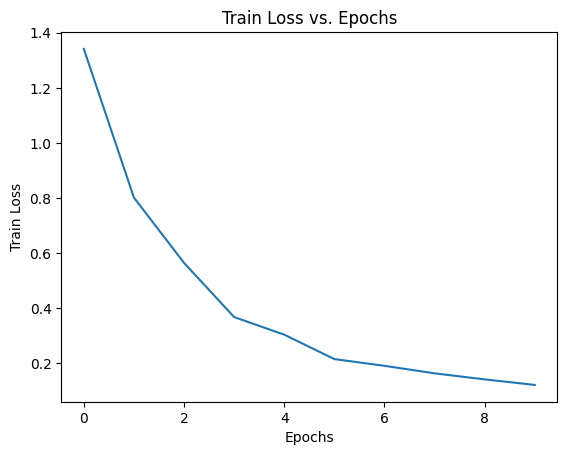

In [13]:
plt.plot(train_epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.title("Train Loss vs. Epochs")

In [14]:
# Set the model in evaluation mode
model.eval()

# Values to keep track of
running_loss = 0
correct = 0
total = 0

with torch.no_grad():
  for data in tqdm(testloader):

    inputs, labels = data[0].to(device), data[1].to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    running_loss += loss.item() * inputs.size(0)
    total += inputs.size(0)
    correct += torch.sum(labels == torch.argmax(outputs, dim=1)).item()

test_loss = running_loss / total
test_accuracy = (correct / total) * 100

print(f"\nTest Loss: {test_loss:.3f}, Test Acc: {test_accuracy:.2f}%")

100%|██████████| 125/125 [00:23<00:00,  5.34it/s]


Test Loss: 0.401, Test Acc: 89.55%
